<a href="https://colab.research.google.com/github/Meddebma/pyradiomics/blob/master/Classification_HBI_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install "monai--weekly[nibabel, skimage, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil]"
%pip install itkwidgets
%pip install SimpleITK
%pip install itk-io
%pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
!pip install -q itkwidgets statsmodels seaborn
import logging
import os
import sys
import tempfile
import shutil

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import SimpleITK as sitk
import monai
from monai.networks.nets import DenseNet121, Classifier, EfficientNet, EfficientNetBN, ViT
from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import first
from monai.visualize import GradCAM
from monai.metrics import ConfusionMatrixMetric, get_confusion_matrix
from monai.data import CacheDataset, DataLoader, ImageDataset, ITKReader, PILReader, Dataset, partition_dataset_classes, partition_dataset
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, 
)
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from torch.utils.data import DataLoader 
from monai.transforms import Transform
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandRotate90,
    Invertd,
    Lambda,
    Resize,
    Orientation,
    Orientationd,
    EnsureChannelFirstd,
    ScaleIntensity,
    AsChannelFirst,
    AsChannelLast,
    Activations,
    AddChannel,
    AddChanneld,
    ToTensord,
    Resized,
    AsDiscrete,
    Spacingd,
    EnsureChannelFirst,
    RepeatChannel,
    RemoveRepeatedChannel,
    ScaleIntensityRanged,
    SplitChannel,
    SqueezeDim,
    ToTensor,
    CropForegroundd,
    Randomizable,
    LoadImaged,
    ToTensord,
    MaskIntensityd,
    Flip,
    MaskIntensity,
    ScaleIntensityd,
    EnsureType,
    EnsureTyped,
)
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import seaborn as sns 
import itk
import tensorboard
from itkwidgets import view

from glob import glob
import logging
from abc import ABC, abstractmethod
from typing import Any, Callable, Dict, Generator, Hashable, Iterable, List, Optional, Tuple
from monai.utils import first, set_determinism
from math import ceil
#from downloaddata import fetch_data as fdata
import matplotlib.pyplot as plt


import numpy as np
import torch

import numpy as np
from monai.transforms import Transform, AddChannel, AsChannelFirst


logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 0.9.dev2220
Numpy version: 1.22.3
Pytorch version: 1.12.0a0+bd13bc6
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 1e9b0084b1d32b4a72f6e309bacde1390526d38f
MONAI __file__: /opt/conda/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.13.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.19.1
mlflow version: 1.25.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



**Data Direction**

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# set this in your environment or previous cell to wherever IXI is downloaded and extracted
RunFolder = "/HippoDense/runFolder"
DatasetDir = "/Datasets/01_P_Classification_all_hippo"
labels = []
images = []
NotFitImages = []
for root, dirs, files in os.walk(os.path.abspath(DatasetDir)):
    for file in files:
        if file.split("_")[-3] == "L":
            labels.append(2)
            images.append(os.path.join(root, file))
        elif file.split("_")[-3] == "E":
            labels.append(1)
            images.append(os.path.join(root, file))
        elif file.split("_")[-2] == "Normal":
            labels.append(0)
            images.append(os.path.join(root, file))
        elif file.split("_")[-2] == "Dementia":
            labels.append(3)
            images.append(os.path.join(root, file))
        else:
            NotFitImages.append(file)
            # print(file)
print("{}: images cannot be used.".format(len(NotFitImages)))
labels = np.array(labels)
# # labels = np.load(
#     '/workspace/monai/MONAI-tutorials/3d_classification/01_P_Classification_all_labels.npy')
NumClasses = len(np.unique(labels))
# ClassLabels = np.array(Labels)
if len(images)==len(labels):
    print("{}: total images prepared with {} different classes".format(len(images), NumClasses))
# images


2: images cannot be used.
364: total images prepared with 4 different classes


In [4]:
print(len(images))
#print(len(segmentations))
print(len(labels))


364
364


In [5]:
#!pip install ipywidgets
# img = itk.image_view_from_array(images[3])
img = sitk.ReadImage(images[3])
img = sitk.GetArrayFromImage(img)
#view(img)
# print(img.shape)
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
#print(f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}")
# Define a function to visualize the data
breakpoint()

for i in img:
  def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(img[layer, :,  :], cmap='gray');
    plt.title('Explore Layers of Hippocampus', fontsize=20)
    plt.axis('off')
    return layer
    
# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(2, img.shape[2] - 1));

interactive(children=(IntSlider(value=128, description='layer', max=255, min=2), Output()), _dom_classes=('wid…

**Loading Data**

In [6]:
# set_determinism(seed=0)
# torch.cuda.is_available()
pin_memory = torch.cuda.is_available()
data = [{"image": i, "label": l} for i, l in zip(images, labels)]

transforms = Compose([
    LoadImaged(keys=["image"]),
    AddChanneld(keys=["image"]),
    Orientationd(keys=["image"], axcodes="PLI"),
    Resized(keys=["image"], spatial_size=(96, 96, 96)),
    ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    #MaskIntensityd(keys="image", mask_key="seg"),
    EnsureTyped(keys=["image"]),
])


data_partition= partition_dataset_classes(data, labels.tolist(), shuffle=True, ratios=[0.8, 0.2])


In [10]:
torch.cuda.is_available()

True

In [7]:

# create a training data loader
train_ds = CacheDataset(data=data_partition[0], num_workers=256, transform=transforms)

train_loader = DataLoader(train_ds, batch_size=2, num_workers=256, shuffle=False,  pin_memory=pin_memory)
print("Train Loader")
# create a validation data loader
val_ds = CacheDataset(data=data_partition[1],num_workers=256, transform=transforms)
val_loader = DataLoader(val_ds, batch_size=2,num_workers=256, shuffle=False, pin_memory=pin_memory)

# create a test data loader
test_ds = CacheDataset(data=data_partition[1],num_workers=256, transform=transforms)
test_loader = DataLoader(test_ds, batch_size=2, shuffle=False, num_workers=256, pin_memory=pin_memory)

post_pred = Compose([EnsureType(), Activations(softmax=True)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

Loading dataset: 100%|██████████| 292/292 [00:12<00:00, 23.54it/s]


Train Loader


Loading dataset: 100%|██████████| 72/72 [00:03<00:00, 19.85it/s]
`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.


**Training**

In [11]:

device = torch.device("cpu")
model = monai.networks.nets.ViT(in_channels=1, img_size=(96,96,96), patch_size=(16,16,16), pos_embed='conv', classification=True).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
auc_metric = ROCAUCMetric()

In [20]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
acc_values = []
writer = SummaryWriter()
max_epochs = 100
for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            print(len(labels), len(outputs))
            print("*" * 15)
            print(labels)
            print("*" * 15)
            print(outputs)
            print("*" * 15)
            break 
            loss = loss_function(outputs[0], labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        break
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                for val_data in val_loader:
                    val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                    y_pred = torch.cat([y_pred, model(val_images)[0]], dim=0)
                    y = torch.cat([y, val_labels], dim=0)

                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                y_onehot = [post_label(i) for i in decollate_batch(y)]
                y_pred_act = [post_pred(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                auc_result = auc_metric.aggregate()
                auc_metric.reset()
                del y_pred_act, y_onehot
                metric_values.append(auc_result)
                

                if acc_metric > best_metric:
                    best_metric = acc_metric
                    best_metric_epoch = epoch + 1
                    
                    torch.save(model.state_dict(), "/content/drive/My Drive/Brain_AI/best_metric_model_classification_ViT100.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current accuracy: {:.4f} current AUC: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                        epoch + 1, acc_metric, auc_result, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_accuracy", acc_metric, epoch + 1)
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
2 2
***************
tensor([2, 3])
***************
(tensor([[-0.0701, -0.3227],
        [-0.0701, -0.3227]], grad_fn=<TanhBackward0>), [tensor([[[-0.3520, -0.0570, -0.5171,  ...,  0.3668,  0.3256,  0.4829],
         [-0.6149, -0.2168, -0.6511,  ...,  0.3705,  0.1111,  0.7452],
         [-0.5913, -0.2258, -0.6505,  ...,  0.3602,  0.0711,  0.7402],
         ...,
         [-0.6363, -0.1863, -0.6789,  ...,  0.3004,  0.1086,  0.7200],
         [-0.5890, -0.1843, -0.6453,  ...,  0.2885,  0.0502,  0.6918],
         [-0.5851, -0.2024, -0.7033,  ...,  0.3520,  0.1032,  0.6993]],

        [[-0.3520, -0.0570, -0.5171,  ...,  0.3668,  0.3256,  0.4829],
         [-0.6149, -0.2167, -0.6511,  ...,  0.3705,  0.1111,  0.7452],
         [-0.5913, -0.2258, -0.6505,  ...,  0.3602,  0.0711,  0.7402],
         ...,
         [-0.6363, -0.1862, -0.6789,  ...,  0.3004,  0.1086,  0.7200],
         [-0.5890, -0.1843, -0.6453,  ...,  0.2885,  0.0502,  0.6918],
         [-0.5851, -0.2024, -0

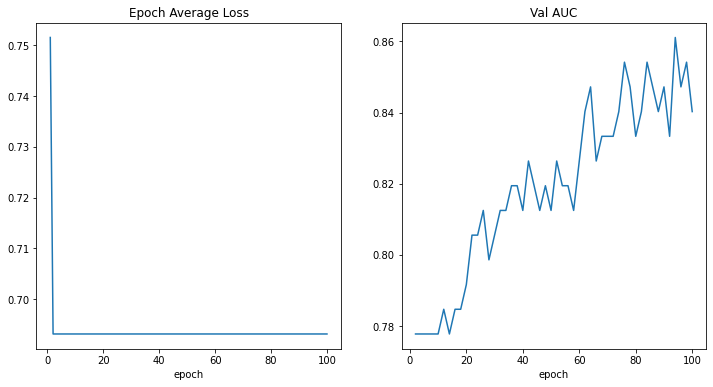

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

**Evaluation Metrics**

                         precision    recall  f1-score   support

          Normal_Befund       0.50      1.00      0.67         6
Hypoxischer_Hirnschaden       0.00      0.00      0.00         6

               accuracy                           0.50        12
              macro avg       0.25      0.50      0.33        12
           weighted avg       0.25      0.50      0.33        12



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


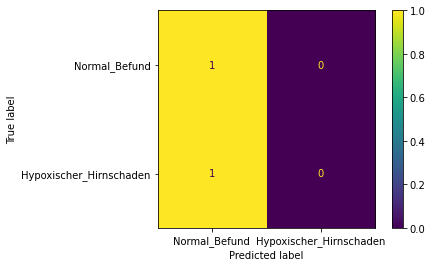

In [ ]:
from enum import Enum
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
class Diagnosis(Enum):
    Normal_Befund = 0
    Hypoxischer_Hirnschaden = 1
    

%matplotlib inline
# Load best model
model.load_state_dict(torch.load("/content/drive/My Drive/Brain_AI/best_metric_model_classification_ViT100.pth"))
model.to(device)
model.eval()

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for val_data in val_loader:
        val_images, val_labels = val_data["image"].to(
            device), val_data["label"].to(device),

        outputs = model(val_images)
        y_pred = torch.cat([y_pred, outputs.argmax(dim=1)], dim=0)
        y = torch.cat([y, val_labels], dim=0)

print(classification_report(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix (
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
cmm = ConfusionMatrixMetric (include_background=True, metric_name=["sensitivity","specificity","negative predictive value"])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis],
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])